<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM

In [2]:
! wget -q https://xgass.icrar.org/assets/data/xGASS_representative_sample.ascii

In [3]:
# Loading the xGASS dataset with specific columns selected
xGASStb= np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[8,9,10,16,18,1,23,24,26,27,31,32], unpack= 'true')
# Loading the specfic columns with flags as separate arrays
HIsrc, HI_FLAG = np.loadtxt('xGASS_representative_sample.ascii', dtype = 'float', usecols=[26,27], unpack= 'true')
# Removing data with an index that falls into the conditions HI_FLAG >1 or HI_FLAG <90
xGASSRd = np.delete(xGASStb, np.where((HI_FLAG >1) & (HI_FLAG < 90)), axis = 1)
xGASST = xGASSRd.T

# Assigning the 1d arrays to the correct column of data
zSDSS = xGASST[:,0]
Dlum = xGASST[:,1]
lgMstar = xGASST[:,2]
petro90r = xGASST[:,3]
lgmust = xGASST[:,4]
lgSFR_tot_median = xGASST[:,5]
SFR_best = xGASST[:,6]
SFRerr_best = xGASST[:,7]
HIsrc = xGASST[:,8]
HI_FLAG = xGASST[:,9]
lgMHI = xGASST[:,10]
lgGF = xGASST[:,11]

In [4]:
# Testing to ensure the correct arrays are filled with the correct values
print(zSDSS)
print(Dlum)
print(lgMstar)
print(petro90r)
print(lgmust)
print(lgSFR_tot_median)
print(SFR_best)
print(SFRerr_best)
print(HIsrc)
print(HI_FLAG)
print(lgMHI)
print(lgGF)

[0.03618 0.03573 0.04201 ... 0.04656 0.02704 0.03797]
[159.2 157.2 185.7 ... 206.5 118.2 167.3]
[10.709 10.539 10.625 ... 10.946 10.334 10.25 ]
[10.51  9.96  7.01 ... 13.09  6.66 14.09]
[9.18 9.05 9.32 ... 9.08 9.37 8.12]
[101866. 101874. 101876. ... 332851. 332201. 332883.]
[0.82985944 0.03869768 0.0620131  ... 2.902701   0.03280856 0.93741816]
[0.         0.07982571 0.15414698 ... 0.42542186 0.         0.28900966]
[3. 4. 3. ... 4. 4. 3.]
[ 1. 99.  1. ... 99. 99.  1.]
[9.603 8.74  9.244 ... 9.183 8.664 9.517]
[-1.106 -1.799 -1.381 ... -1.763 -1.67  -0.733]


In [5]:
# Finding all the rows in the xGASS data with HIsrc < 4, if HIsrc = 4, no detection of HI
# Subtracting no HI detection
# All HI-detected galaxy properties below
HIndet = np.where(HIsrc >= 4)[0]

zSDSS1 = np.delete(zSDSS, (HIndet))
Dlum1 = np.delete(Dlum, (HIndet))
lgMstar1 = np.delete(lgMstar, (HIndet))
petro90r1 = np.delete(petro90r, (HIndet))
lgmust1 = np.delete(lgmust, (HIndet))
lgSFR_tot_median1 = np.delete(lgSFR_tot_median, (HIndet))
SFR_best1 = np.delete(SFR_best, (HIndet))
lgSFR1 = np.log10(SFR_best1)
SFRerr_best1 = np.delete(SFRerr_best, (HIndet))
HIsrc1 = np.delete(HIsrc, (HIndet))
HI_FLAG1 = np.delete(HI_FLAG, (HIndet))
lgMHI1 = np.delete(lgMHI, (HIndet))
lgGF1 = np.delete(lgGF, (HIndet))

# Subtracting HI detection
# All no-HI-detected galaxies below
HIdet = np.where(HIsrc < 4)[0]

zSDSS2 = np.delete(zSDSS, (HIdet))
Dlum2 = np.delete(Dlum, (HIdet))
lgMstar2 = np.delete(lgMstar, (HIdet))
petro90r2 = np.delete(petro90r, (HIdet))
lgmust2 = np.delete(lgmust, (HIdet))
lgSFR_tot_median2 = np.delete(lgSFR_tot_median, (HIdet))
SFR_best2 = np.delete(SFR_best, (HIdet))
SFRerr_best2 = np.delete(SFRerr_best, (HIdet))
HIsrc2 = np.delete(HIsrc, (HIdet))
HI_FLAG2 = np.delete(HI_FLAG, (HIdet))
lgMHI2 = np.delete(lgMHI, (HIdet))
lgGF2 = np.delete(lgGF, (HIdet))

# The bottom two prints should sum to the top print statement
print(len(lgMstar))
print(len(lgMstar1))
print(len(lgMstar2))

1066
691
375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


In [6]:
# Finding the running median of the HI detections
# Arrays for the bins
bins = np.linspace(9, 12, 13)
bins2 = np.linspace(-1.25, 1, 13)

# Array of zeroes to store the median of each bin
mHIa = np.zeros(len(bins))
median1 = np.zeros(len(bins))
MAD1 = np.zeros(len(bins))

mHIb = np.zeros(len(bins2))
median2 = np.zeros(len(bins2))
MAD2 = np.zeros(len(bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins) -1):
  # Median and MAD for HI of galaxies against stellar mass
  median1[i] = np.median(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  MAD1[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgMstar1 >= bins[i]) & (lgMstar1 <= bins[i+1]))])
  mHIa[i] = median1[i]

for i in range (len(bins2) -1):
  # Median and MAD for HI of galaxies against SFR
  median2[i] = np.median(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  MAD2[i] = stats.median_absolute_deviation(lgMHI1[np.where((lgSFR1 >= bins2[i]) & (lgSFR1 <= bins2[i+1]))])
  mHIb[i] = median2[i]

# Working out the upper and lower bounds of the median absolute deviation
pMAD1 = mHIa + MAD1
nMAD1 = mHIa - MAD1
pMAD2 = mHIb + MAD2
nMAD2 = mHIb - MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


"\nplt.subplot(223)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(M*) [M$_{solar}$]')\nplt.ylabel('log(M$_{HI}$)')\n\nplt.subplot(224)\nplt.plot(,, 'k.', label= 'HI detection')\nplt.plot(,, 'r.', label= 'No HI detection')\nplt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')\nplt.ylabel('log(M$_{HI}$)')\n"

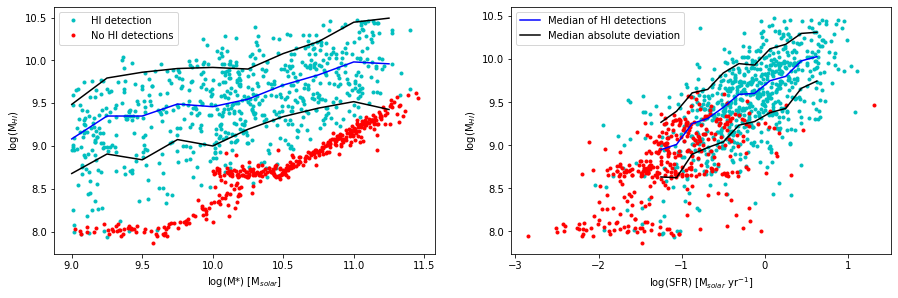

In [7]:
# Global HI mass and HI mass contained in the optical regions with median lines
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.plot(lgMstar1, lgMHI1, 'c.', label= 'HI detection')
plt.plot(lgMstar2, lgMHI2, 'r.', label= 'No HI detections')
plt.plot(bins[:-2], mHIa[:-2], 'b-')
plt.plot(bins[:-2], pMAD1[:-2], 'k-')
plt.plot(bins[:-2], nMAD1[:-2], 'k-')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='upper left');

plt.subplot(222)
plt.plot(np.log10(SFR_best1), lgMHI1, 'c.')
plt.plot(np.log10(SFR_best2), lgMHI2, 'r.')
plt.plot(bins2[:-2], mHIb[:-2], 'b-', label = 'Median of HI detections')
plt.plot(bins2[:-2], pMAD2[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(bins2[:-2], nMAD2[:-2], 'k-')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
plt.legend(loc='upper left');

'''
plt.subplot(223)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(M*) [M$_{solar}$]')
plt.ylabel('log(M$_{HI}$)')

plt.subplot(224)
plt.plot(,, 'k.', label= 'HI detection')
plt.plot(,, 'r.', label= 'No HI detection')
plt.xlabel('log(SFR) [M$_{solar}$ yr$^{-1}$]')
plt.ylabel('log(M$_{HI}$)')
'''

In [8]:
# DHI- MHI relation
# For HI detections
lgDHI1 = 0.506*lgMHI1 - 3.293
MHI1 = 10**lgMHI1
DHI1 = 10**lgDHI1
RHI1 = 0.5*DHI1

# For no HI detection
lgDHI2 = 0.506*lgMHI2 - 3.293
MHI2 = 10**lgMHI2
DHI2 = 10**lgDHI2
RHI2 = 0.5*DHI2

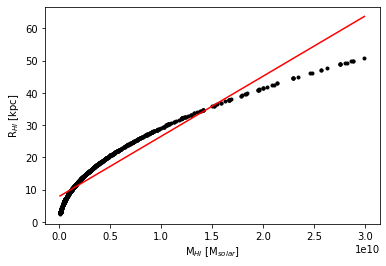

In [9]:
# DHI- MHI relation
lgDHI = 0.506*lgMHI - 3.293
MHI = 10**lgMHI
DHI = 10**lgDHI
RHI = 0.5*DHI

# Plotting the R(HI)-M(HI) relation
plt.figure()
plt.plot(MHI, RHI, 'k.')
plt.ylabel('R$_{HI}$ [kpc]')
plt.xlabel('M$_{HI}$ [M$_{solar}$]')

# Fitting a line to the RHI-MHI relation
x = MHI
p = np.linspace(min(x), max(x), 1000)
y = RHI
def linfun(x, m, c): 
    return m*x + c
p0 = np.array([])
popt, pcov = curve_fit(linfun, x, y)
plt.plot(p, linfun(p, *popt), 'r');

0.7407218209453733


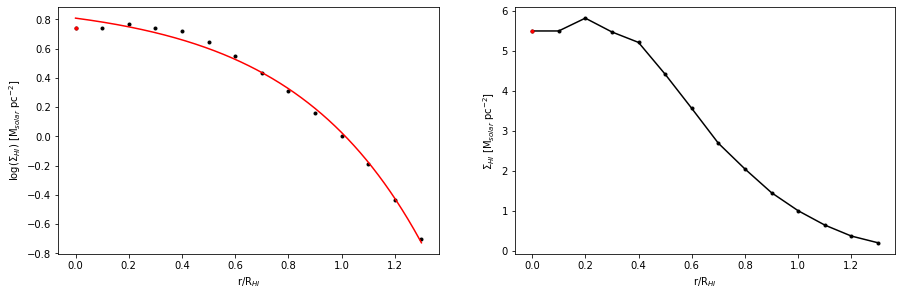

In [10]:
# Need to create a median HI profile of galaxies- (data from Wang et al 2020)
rrHI=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
SigHI=np.array([5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
lgSigHI = np.log10(SigHI)

x1 = np.flip(rrHI)
y1 = lgSigHI
f = interpolate.interp1d(x1, y1, fill_value = "extrapolate")
zpoint = f(max(np.flip(rrHI)))
print(zpoint)

newrrHI = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3])
newSigHI=np.array([(10**zpoint),5.50455,5.82575,5.47971,5.21774,4.42226,3.56687,2.69376,2.04850,1.45364,1.00281,0.643707,0.368113,0.2])
newlgSigHI = np.log10(newSigHI)

# Noticable data 'gap' from 0 - 0.1 RHI
# Fitting a curve to the data will allow a different range to be set
# The data ends at 0.1r/RHI, using the fitted curve this can be extrapolated back to r/RHI = 0
x = newrrHI
p = np.linspace(0, max(newrrHI), 1000)
y = newlgSigHI
def curvefun(x, a, b, c, d): 
    return -a*np.exp((x*b)- c) + d
p0 = np.array([1,1,1,1])
popt, pcov = curve_fit(curvefun, x, y, p0)

# Plotting the median HI profile using Wang 2020 data
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(newrrHI, newlgSigHI, 'k.')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('log(Σ$_{HI}$) [M$_{solar}$ pc$^{-2}$]')
plt.plot(p, curvefun(p, *popt), 'r-')
plt.plot(0, zpoint, 'r.');

plt.subplot(222)
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(0, 10**zpoint, 'r.');

30.0


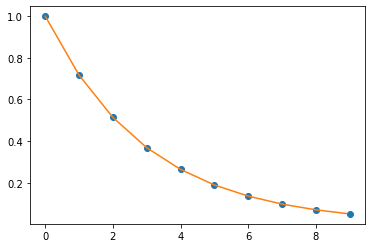

In [11]:
x = [1, 2, 3, 4, 5]
y = [5, 10, 15, 20, 25]
f = interpolate.interp1d(x, y, fill_value = "extrapolate")
print(f(6))
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)
xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-');

In [27]:
# Converting the petrosian flux in the r band from arcsec to parsec
# Assuming the following cosmology
cosmology = FlatLambdaCDM(H0 = 70, Om0 = 0.3, Tcmb0 = 2.273)

# Converting the data, where .arcsec_per_kpc_proper is the equation of proper distance, using the redshift of the galaxies
arckpc1 = cosmology.arcsec_per_kpc_proper(zSDSS1)
r90kpc1 = petro90r1/arckpc1
# Normalise r90 by dividing by RHI
r90norm1 = (r90kpc1/RHI1)
#print(r90norm1)

# Defining a function to associate the r90/RHI to the surface density profile based on the equation fitted to the previous graph

profiler90 = curvefun(r90norm1, 1, 1, 1, 1)

SyntaxError: ignored

In [ ]:
plt.plot(newrrHI, newSigHI, 'k.-')
plt.xlabel('r/R$_{HI}$')
plt.ylabel('Σ$_{HI}$ [M$_{solar}$ pc$^{-2}$]')
plt.plot(0, 10**zpoint, 'r.');